# Time series analysis of coronavirus in states of India with keras.
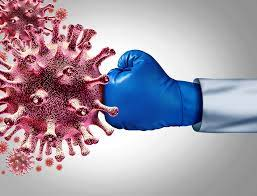



## Importing dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
df = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv')

In [ ]:
df.head()

In [ ]:
df['Country/Region'].unique()

## Data visualization with data of India

In [ ]:
data = df[df['Country/Region'] == 'India'] # Picking data of India 

In [ ]:
data.head()

In [ ]:
data['Confirmed'].head(50)

In [ ]:
#Plotting cumulative cases stored in the feature 'Confirmed'

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(data['Confirmed'])
plt.show()

In [ ]:
data.size

In [ ]:
data.tail()

In [ ]:
# Taking data of West Bengal for analysis

In [ ]:
data_west_bengal = data[data['Province/State'] == 'West Bengal']

In [ ]:
# Plotiing confirmed cases

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(data_west_bengal['Confirmed'])
plt.show()

In [ ]:
# Plotiing deaths

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(data_west_bengal['Deaths'])
plt.show()

In [ ]:
# The function plots the deaths and cases per day of a state and returns the lists 
# of cases/day and deaths/day
def plot_deaths_cases(data_original,place,ret  = False):
    data = data_original.reset_index()
    deaths = [0]
    j = 0
    for i in data['Deaths']:
        deaths.append(i-j)
        j = i
    deaths = deaths[2:]    
    confirmed = [0]
    j = 0
    for i in data['Confirmed']:
        confirmed.append(i-j)
        j = i 
    confirmed = confirmed[2:]    
    plt.subplot(2,1,1)    
#     plt.figure(figsize = (12,7))
    plt.plot(deaths[2:])
    plt.title('No of Deaths in '+place+' each day')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    plt.subplot(2,1,2)
#     plt.figure(figsize = (12,7))
    plt.plot(confirmed[2:])
    plt.title('No of Cases in '+place+' each day')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    if ret:
        return deaths,confirmed

In [ ]:
# deaths = [0]
# j = 0
# for i in data_west_bengal['Deaths']:
#     deaths.append(i-j)
#     j = i

In [ ]:
# deaths = deaths[2:]

In [ ]:
plot_deaths_cases(data_west_bengal,'West Bengal')

In [ ]:
data['Province/State'].unique()

In [ ]:
# Picking data of Delhi for visualization

In [ ]:
data_delhi = data[data['Province/State']=='Delhi']

In [ ]:
plot_deaths_cases(data_delhi,'Delhi')

In [ ]:
data['Deaths'].tail(20)

In [ ]:
# Picking data of Uttar Pradesh for visualization

In [ ]:
data_up = data[data['Province/State']=='Uttar Pradesh']

In [ ]:
plot_deaths_cases(data_up,'Uttar Pradesh')

In [ ]:
# Picking data of Maharashtra for visualization

In [ ]:
data_maha = data[data['Province/State']=='Maharashtra']

In [ ]:
deaths_maha,cases_maha = plot_deaths_cases(data_maha,'Maharashtra',ret = True)

## Picking Maharashtra's Data for analysis

In [ ]:
# Using Naive Prediction model

In [ ]:
deaths_naive = [0]
cases_naive = [0]
for i in deaths_maha[1:]:
    deaths_naive.append(i)
for i in cases_maha[1:]:
    cases_naive.append(i)    

In [ ]:
plt.subplot(2,1,1)    
plt.plot(deaths_maha,label = 'Actual Deaths')
plt.plot(deaths_naive,label = 'Naive Forecast')
plt.legend(loc = 'upper left')
plt.title('Naive Deaths vs Actual Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.show()
plt.subplot(2,1,2)
plt.plot(cases_maha,label = 'Actual Cases')
plt.plot(cases_naive,label = 'Naive Forecast')
plt.legend(loc = 'upper left')
plt.title('Naive Cases vs Actual Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

In [ ]:
# Naive forecast works better than complex models sometimes as can be inferred from the graphs

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(deaths_maha,deaths_naive).numpy())
print(mae(cases_maha,cases_naive).numpy())

In [ ]:
# /dataset = tf.data.Dataset.from_tensor_slices(
#                [1,2,3,4,5,6,7,8,9])
# print(list(dataset.as_numpy_iterator()))
# dataset = dataset.window(2,shift=1,drop_remainder = True)
# # dataset = dataset.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
# for i in dataset:
#     print(list(i.as_numpy_iterator()))
# dataset = dataset.flat_map(lambda w: w.batch(2))
# print(list(dataset.as_numpy_iterator()))
# dataset = dataset.map(lambda w: (w[:-1],w[-1]))
# print(list(dataset.as_numpy_iterator()))
# dataset = dataset.shuffle(len([1,2,3,4,5,6,7,8,9]))
# print(list(dataset.as_numpy_iterator()))

## Preparing data for Keras net training

In [ ]:
# The function converts a list into a pair of 4 consecutive values and the 5th consecutive value 
# of the list, it then shuffles them, the first 4 values act as features and the 5th values as
# target varaible like a machine learning regression problem
def window_dataset(series,window_size,batch_size = 32):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.map(lambda w: (w[:-1],w[-1]))
  ds = ds.shuffle(len(series))
  return ds.batch(32).prefetch(1)

In [ ]:
deaths_ds = window_dataset(deaths_maha,5)

In [ ]:
# printing final dataset

In [ ]:
list(deaths_ds.as_numpy_iterator())

# Creating and training the model

In [ ]:
# Splitiing deaths series into train and validation sets

In [ ]:
split = 300
deaths_train = deaths_maha[0:split]
deaths_val = deaths_maha[split:]

In [ ]:
window_size = 5
train_set = window_dataset(deaths_train,window_size)
valid_set = window_dataset(deaths_val,window_size)

model = tf.keras.models.Sequential([
                                 tf.keras.layers.Dense(1,input_shape = [window_size,])
])
optimizer = tf.keras.optimizers.SGD(lr = 1e-5,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae']
              )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs = 500,validation_data = valid_set,callbacks = [early_stopping])

In [ ]:
# THe function generates predictions from the model for a given series
def model_forecast(model,series,window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

In [ ]:
forecast =  model_forecast(model,deaths_maha[split-window_size:-1],window_size)
forecast = forecast[:,0]

In [ ]:
# Plotting forecasted and actual deaths

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(forecast,label = 'Forecasted Deaths')
plt.plot(deaths_maha[split:],label = 'Actual Deaths')
plt.legend(loc = 'upper left')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Deaths/day')
plt.title('Predicted Deaths vs Actual deaths in Maharashtra')
plt.show()

In [ ]:
mae_linear_model = mae(deaths_maha[split:],forecast)
print(mae_linear_model.numpy())

In [ ]:
# Eliminating missing values from the cases data which are equal to zero
cases = []
for i in cases_maha:
    if i!=0:
        cases.append(i)

In [ ]:
len(cases)

In [ ]:
split = 295
cases_train = cases[0:split]
cases_val = cases[split:]

In [ ]:
# Training model for cases forecasting

In [ ]:
window_size = 4
train_set = window_dataset(cases_train,window_size)
valid_set = window_dataset(cases_val,window_size)

model = tf.keras.models.Sequential([
                                 tf.keras.layers.Dense(1,input_shape = [window_size,])
])
optimizer = tf.keras.optimizers.SGD(lr = 1e-6,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae']
              )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only = True)
model.fit(train_set,epochs = 500,validation_data = valid_set,callbacks = [early_stopping,model_check])

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
forecast_cases =  model_forecast(model,cases[split-window_size:-1],window_size)
forecast_cases = forecast_cases[:,0]

In [ ]:
# Plotting forecasted and actual cases

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(forecast_cases,label = 'Forecasted Cases')
plt.plot(cases[split:],label = 'Actual Cases')
plt.legend(loc = 'upper left')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Cases/day')
plt.title('Predicted Cases/day vs Actual Cases/day in Maharashtra')
plt.show()

In [ ]:
mae_linear_model = mae(cases[split:],forecast_cases)
print(mae_linear_model.numpy())